# Building CNN From Scratch

Convolutional neural network (CNN) is the state-of-art technique for analyzing multidimensional signals such as images. There are a lot of different libraries available to allow us use this technique in image processing, but these libraries seperate us from having full control of the neural networks. So understanding the implementing process is crucial and will be useful in the actual usage of the CNN. 

In this notebook, I am going to follow the guidelines by Ahmed Gad and [his post](https://www.kdnuggets.com/2018/04/building-convolutional-neural-network-numpy-scratch.html). However, the dataset I am using is the MNIST dataset which can be found in [here](https://www.kaggle.com/c/digit-recognizer/data). 

## 1. Guidelines for building CNN

In the tutorial by Ahmed Gad, the CNN is created only by NumPy library with three layers: convolution, ReLU, and max pooling. The steps involved are as follows:

1. Reading the input image.
2. Preparing filters.
3. Conv layer: Convolving each filter wih the input image.
4. ReLu layer: Applying ReLU activation function on the feature maps (out of conv layer)
5. Max Pooling layer: Applying the pooling operation on the output of ReLU layer.


### (1) Reading input image

Since we are doing CNN on datasets,so in the preprocessing steps, ours will take more exploration into the dataset rather than looking at the graphs. MNIST dataset is a set of calligraphcal images of digit 1-9. In the training dataset, there are approximately 4000+ numbers for each of the digits which gives a good learning sample for our NN. 

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

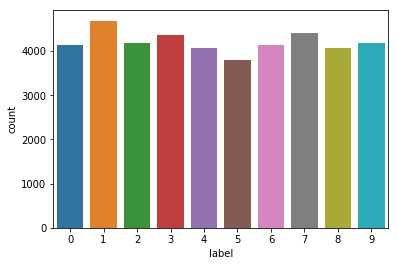

In [19]:
Y_train = train['label']
X_train = train.drop(labels=['label'], axis = 1)


g = sns.countplot(Y_train)

The MNIST dataset has been stock into pandas.DataFrame as 1D vectors of 784 values. So it is easier to process if we have reshaped it into a $28 \times 28 \times 1$ 3D matrices. Check [here](https://stackoverflow.com/questions/41778632/why-is-the-x-variable-tensor-reshaped-with-1-in-the-mnist-tutorial-for-tensorfl) for why we need to reshape it to 4 dimension.

In [42]:
X_train2 = X_train.values.reshape(-1,28,28,1)

In [10]:
test = test.values.reshape(-1,28,28,1)

Now we can take a look at the actual example in our graphs. It will make better sense if we can take a look at it before applying the filters.

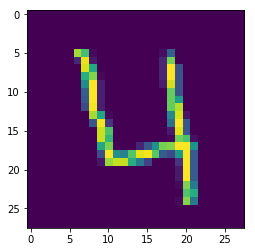

In [43]:
ex = plt.imshow(X_train2[3][:,:,0])
# or use plt.imshow(,cmap = 'grey')

### （2）Preparing filters

The filters bank for the first conv layer (conv) is a zero array created according to the number of filters and size of each filter. For 2D image such as greysclae, we typically have filter = 2 because of the image does not have depth. If the image is RGB with three channels, the filter size should be 3. 

In [144]:
l1_filter = np.zeros((2,3,3))
l1_filter[0,:,:] = np.array([[[-1,0,1],
                              [-1,0,1],
                              [-1,0,1]]])
l1_filter[1,:,:] = np.array([[[1,1,1],
                              [0,0,0],
                              [-1,-1,-1]]])

### (3) Conv Layer

After preparing the filters, next is to convolve te input image. To convolve the images with filters bank using using a function called conv. The **conv** function is defined in the following, thanks to the credit of Ahmed.

In [173]:
import numpy
def conv(img, conv_filter):  
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.  
        if img.shape[-1] != conv_filter.shape[-1]:  
            print("Error: Number of channels in both image and filter must match.")  
            sys.exit()  
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.  
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')  
        sys.exit()  
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.  
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')  
        sys.exit()  
   
     # An empty feature map to hold the output of convolving the filter(s) with the image.  
    feature_maps = numpy.zeros((img.shape[0]-conv_filter.shape[1]+1,   
                                 img.shape[1]-conv_filter.shape[1]+1,   
                                 conv_filter.shape[0]))  
   
     # Convolving the image by the filter(s).  
    for filter_num in range(conv_filter.shape[0]):  
         
        print("Filter ", filter_num + 1)  
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank. 
         
        """  
         Checking if there are mutliple channels for the single filter. 
         If so, then each channel will convolve the image. 
         The result of all convolutions are summed to return a single feature map. 
        """  
        if len(curr_filter.shape) > 2:  
             
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.               
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.  
                conv_map = conv_map + conv_(img[:, :, ch_num],   
                                   curr_filter[:, :, ch_num])  
         
        else: # There is just a single channel in the filter.  
             conv_map = conv_(img, curr_filter)  
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.

The reasoning behind the above function starts by ensuring that the depth of each filter is equal to the number of image channels. It first checks if the channel and the filter have a depth, and if a depth exists, then it will check for their inequality. Additionally, the function will check the size of the filter is odd and filter dimensions are equal. Which means the number of rows and columns are odd and equal.

***Side Note: Why we usually have a filter size of odd numbers?***

The intent of convolution is to encode source data matrix(entire image) in terms of filter or kernel. More specifically, we are trying to encode the pixels in the neighborhood of anchor/source pixels. Typically, the source pixel is the anchor point at which the kernel is centered and we are encoding all the neighboring pixels, including the anchor/source pixel. Since the kernel is symmetrically shaped (not symmetric in kernel values), there are equal number(n) of pixel on all sides (4-connectivity) of the anchor pixel. Therefore, whatever this number of pixels maybe, the length of each side of our symmetrically shaped kernel is 2*n+1 (each side of the anchor + the anchor pixie). and therefore filter/kernel are always odd sized.  (Refer to the following picture for more details) 

![image](https://i.stack.imgur.com/YDusp.png)





Because there is no stride nr padding, the feature map size will be equal to

(img_rows - filter_rows+1, image_columns - filter_columns +1, num_filters)

If the image to be convolved has more than one channel, then the filter must has a depth equal to such number of channels. Convolution in this case is done by concolving each image chanel with its corresponding channel in the filter. Finally, the sum of the results will be the output of feature map.

The function **conv** accepts the input image and the filter bank but does not apply concolution its own. It just passes each set of input-filter paris to be convolved to the conv_ function. This is just for making the code simpler to investigate. The following is the code for **conv_** function:

In [171]:
def conv_(img, conv_filter):  
    filter_size = conv_filter.shape[0]  
    result = numpy.zeros((img.shape))  
    #Looping through the image to apply the convolution operation.  
    for r in numpy.uint16(numpy.arange(filter_size/2,   
                            img.shape[0]-filter_size/2-2)):  
        for c in numpy.uint16(numpy.arange(filter_size/2, img.shape[1]-filter_size/2-2)):  
            #Getting the current region to get multiplied with the filter.  
            curr_region = img[r:r+filter_size, c:c+filter_size]  
            #Element-wise multipliplication between the current region and the filter.  
            curr_result = curr_region * conv_filter  
            conv_sum = numpy.sum(curr_result) #Summing the result of multiplication.  
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.  
               
    #Clipping the outliers of the result matrix.  
    final_result = result[numpy.uint16(filter_size/2):result.shape[0]-numpy.uint16(filter_size/2),   
                           numpy.uint16(filter_size/2):result.shape[1]-numpy.uint16(filter_size/2)]  
    return final_result  

In [148]:
ex = conv(X_train2[3][:,:,0], l1_filter)

Filter  1
Filter  2


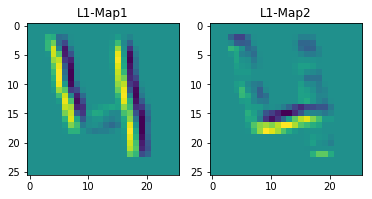

In [149]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(ex[:,:,0])
plt.title('L1-Map1')
f.add_subplot(1,2, 2)
plt.imshow(ex[:,:,1])
plt.title('L1-Map2')
plt.show(block=True)

### (4) ReLU Layer

The ReLU layer is the similar to the Recitifier from the ANN. This layer will applies ReLU activation function over each feature map returned by the conv layer. It will loop though each element in the feature map and return the original value in the feature map if it is larger than 0. Otherwise, it will return 0. It is done in the following function called **relu**:

In [150]:
def relu(feature_map):  
    #Preparing the output of the ReLU activation function.  
    relu_out = numpy.zeros(feature_map.shape)  
    for map_num in range(feature_map.shape[-1]):  
        for r in numpy.arange(0,feature_map.shape[0]):  
            for c in numpy.arange(0, feature_map.shape[1]):  
                relu_out[r, c, map_num] = numpy.max(feature_map[r, c, map_num], 0)
    return relu_out

In [151]:
ex_relu = relu(ex)

***Side note: Why do we need ReLU layer in CNN?***

The ReLu function is $f(x) = max(0,x)$, and we sometimes call it rectifier. Usually this is applied element-wise to the output of some other function, such as matrix-vector product. Rectifier units replace all other activation functions except the readout layer. 

One way ReLu improve neural networks is by speeding up training. Gradients of logistic and hyperbolic tangent networks are smaller than the positive portion of the ReLU. This means that the positive portion is updated more rapidly as training progresses. However, this comes at a cost. The 0 gradient on the left-hand side has its own problem, which is called "dead neurons", in which a gradient update sets the incoming values to a ReLU such that the output is always zero. Modified ReLU units such as ELU(or Leaky ReLU, or PReLU) can ameliorate this.



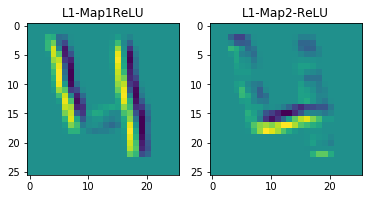

In [152]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(ex_relu[:,:,0])
plt.title('L1-Map1ReLU')
f.add_subplot(1,2, 2)
plt.imshow(ex_relu[:,:,1])
plt.title('L1-Map2-ReLU')
plt.show(block=True)

### (5) Max Pooling Layer

The max pooling payer accepts the output of the ReLu layer and applies the max pooling operation. Basically, max pooling will takes three inputs which are the output of the ReLU layer, pooling mask size and stride. It creates an empty array and holds the output of such layer. The size of such array is specified according to the size of stride arguments. 


Max pooling is done by applying a max filter to (usually) non-overlapping subregions of the initial representation. For example, let's say we have a stride of 2 (meaning the (dx, dy) for stepping over our input will be (2,2)) and won't overlap regions.

For each of the regions represented by the filter, we will take the max of that region and create a new, output matrix where each element is the max of the region in the original input. We can see this in the following example：

![image](https://cdn-images-1.medium.com/max/1600/1*GN_o1mJjCbX_QpYN-ps5eQ.png)

Correspondingly, for multiple feature maps, the operation is as follows: 64 original $224 \times 224$ images, after Max Pooling, becomes $64 \times 112 \times 112$ imagaes, thus achieving the purpose of downsampling.
![image](https://www.codeblogbt.com/img/2018/08/18/1358931-20180727233554402-1570502802.jpg)

A more illustrative calculation can be shown in the following graph, it will tells why max pooling is necessary - because we need to use the property of **translation invariant**. And max pooling will increase the translation invariance. 

For further details in pooling, check this [link](http://www.deeplearningbook.org/contents/convnets.html) for reference. 

![image](https://www.codeblogbt.com/img/2018/08/18/1358931-20180727234303398-77695332.jpg)

The function to implement pooling is as follows. This function accepts three input which are the output of the ReLU layer, pooling mask size, and stride. It simply creates an empty array, as previous, that holds the output of such layer. 

In [153]:
def pooling(feature_map, size=2, stride=2):  
    #Preparing the output of the pooling operation.  
    pool_out = numpy.zeros((numpy.uint16((feature_map.shape[0]-size+1)/stride),  
                              numpy.uint16((feature_map.shape[1]-size+1)/stride),  
                              feature_map.shape[-1]))  
    for map_num in range(feature_map.shape[-1]):  
        r2 = 0  
        for r in numpy.arange(0,feature_map.shape[0]-size-1, stride):  
            c2 = 0  
            for c in numpy.arange(0, feature_map.shape[1]-size-1, stride):  
                pool_out[r2, c2, map_num] = numpy.max(feature_map[r:r+size,  c:c+size])  
                c2 = c2 + 1  
            r2 = r2 +1  
    return pool_out

In [154]:
ex_relu_pool = pooling(ex_relu, 2,2)

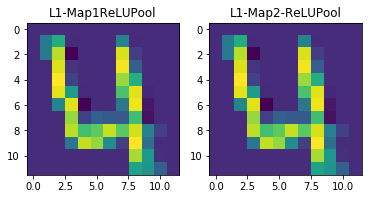

In [156]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(ex_relu_pool[:,:,0])
plt.title('L1-Map1ReLUPool')
f.add_subplot(1,2, 2)
plt.imshow(ex_relu_pool[:,:,1])
plt.title('L1-Map2-ReLUPool')
plt.show(block=True)

We can see that after pooling, the size of the graph shrinks as we have seem in the previous example.

### (6) Stacking layers

Adding the second layer to the previous network will be similar to apply the previous layer sequentially. For example, we can add a new layer called l2 whose filter will be $3 \times 5 \times 5$ (which has 3 filters). In this case, we will expects 3 feature maps from the conv layer, and the same for sucessive layers.

In [167]:
l2_filter = np.random.rand(3,5,5,ex_relu_pool.shape[-1])

In [174]:
l2_fp = conv(ex_relu_pool, l2_filter)
l2_fp_relu = relu(l2_fp)
l2_fp_relu_pool = pooling(l2_fp_relu)

Filter  1
Filter  2
Filter  3


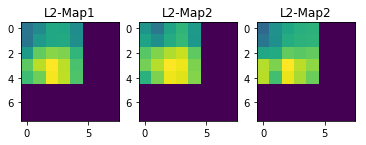

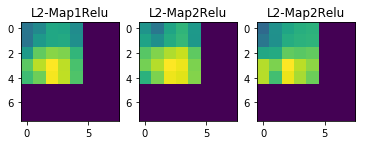

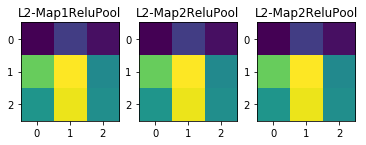

In [188]:
f = plt.figure()
f.add_subplot(1,3, 1)
plt.imshow(l2_fp[:,:,0])
plt.title('L2-Map1')
f.add_subplot(1,3, 2)
plt.imshow(l2_fp[:,:,1])
plt.title('L2-Map2')
f.add_subplot(1,3, 3)
plt.imshow(l2_fp[:,:,2])
plt.title('L2-Map2')
plt.show(block=True)
f = plt.figure()
f.add_subplot(1,3, 1)
plt.imshow(l2_fp_relu[:,:,0])
plt.title('L2-Map1Relu')
f.add_subplot(1,3, 2)
plt.imshow(l2_fp_relu[:,:,1])
plt.title('L2-Map2Relu')
f.add_subplot(1,3, 3)
plt.imshow(l2_fp_relu[:,:,2])
plt.title('L2-Map2Relu')
plt.show(block=True)
f = plt.figure()
f.add_subplot(1,3, 1)
plt.imshow(l2_fp_relu_pool[:,:,0])
plt.title('L2-Map1ReluPool')
f.add_subplot(1,3, 2)
plt.imshow(l2_fp_relu_pool[:,:,1])
plt.title('L2-Map2ReluPool')
f.add_subplot(1,3, 3)
plt.imshow(l2_fp_relu_pool[:,:,2])
plt.title('L2-Map2ReluPool')
plt.show(block=True)

## 2. Building CNN Using Keras from Scratch

Now since we have known how the CNN works from behind the scene, it is generaly easier and faster when using the integrated libraries from Python. Keras is a good library to handle CNN so we can start from here. 

The general steps for building keras is relatively simple, but we need to understand the details when using these libraries correctly. I am using a very straight-forward yet provoking tutorial from kaggle, thanks to the excellent work of Yassine Ghouzam. The Yassine's tutorial is linked in [here](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6).

However, this notebook will also explore other possibilities other than the 

1. Data preparation
2. CNN
3. Evaluate the model
4. Using other networks

### (1) Data Preparation

#### a. Loading libraries

For reference as well as easy navigation, all the packages used in this library will be posted in the coding block. If using anaconda environment, most of the packages we have will not require installment except for Keras. To install Keras, check this [link](https://keras.io/#installation) for complete guideline. To access my setup in Anaconda, check this [link](http://inmachineswetrust.com/posts/deep-learning-setup/) for install it on virtual enviornment. 

**Sidenote**: if ever encounter any problem regarding the numpy, check [this](https://stackoverflow.com/questions/20518632/importerror-numpy-core-multiarray-failed-to-import). 

In [13]:
## For data preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [3]:
## From Keras

from keras.utils.np_utils import to_categorical #convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

#### b. Loading data

Loading data is pretty much the same as in the guideline. We can run a missing value check and do normalization on the data if necessary. 

We also need to encode labels to one-hot vectors in 10 classes. Since we have 10 digits number from 0 to 9, so when we have label of 2, it will converts to $ [ 0,0,1,0,0,0,0,0,0,0 ]$

In [11]:
Y_train2 = to_categorical(Y_train, num_classes=10)

We can also do a train-test splits. In here I choose to do a 80-20 splits which 80% goes to training data and the 20% goes to test data. 

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train2, Y_train2, 
                                                    test_size = 0.2, random_state =0)

### (2) Building CNN 

#### a. Creating a model using Sequential (Basic)

Sequential in Keras is the easiest way to create a CNN, because it simply let us stacking layers one after another. In our case, since the output are expected to be linear, it is very useful to use Sequential to build a prototype for our model. 

Basically, what Yassine does is pretty similar to what we have done in the previous guideline. The only different layer is Dropout and Flatten. 

Dropout acts as a regularization layer which ignores some proportion of nodes in the layer randomly for each training sample. This will force the network to learn features in a distributed way. It is important because it will help improve generalization and reduces overfitting.

Flatten layer is use to convert the final feature maps into one single 1D vector. This flattening step is needed so that you can make sure fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

***Sidenote: Padding*** 

Generally when convoluting the matrix, we will have two problems regarding the pixels: you will have a shrinked input and you tend to throw away information from edges. One way to avoid these matters is by padding: expanding the border with n pixels. 

***Sidenote: Valid Convolution & Same Convolution***

"Valid" is basically no padding. The output will shrink and we generally have $(n \times n) \cdot (f \times f)$ will result in a $(n-f+1, n-f+1)$ matrix

"Same" is using padding so that output size is the same as the input size.

#### b. Building CNN architecture

Now we understand the basics of how we are going to use the Sequential, the next important thing is to build our own CNN architecture that actually works. I use this [guide](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7) to create my own CNN architecture and it is pretty good newbie guide for learning. 

We proposed DenseNets network to build our architecture. Densely connected convolutional networks (DenseNets) is based on observation that if each layer is directly connected to every other layer in a feed-forward way then the network will be more accurate and easier to train. A general outlook on DenseNet can be found in [here](https://arxiv.org/pdf/1608.06993v3.pdf). Also, I am suggesting using [this paper](https://arxiv.org/pdf/1611.09326v2.pdf) to understand fully convolutional DenseNets for semantic segmentation and [this paper](https://arxiv.org/pdf/1707.06316v1.pdf) of DenseNet for optical flow.

We build our first architecture by using LeNet-5 by using the Keras and visualize the trainig.

***Architecture***

- Convolutional NN #1 'same'
    - input: 28x28x1
    - filter: 6, activation: 'relu', size: 3x3
    - output: 28x28x6
- Pooling #1 'valid'
    - input：28x28x1
    - filter：6, activation: 'relu', size: 2x2
    - output: 
- Convolutional NN #1 'Valid'
    - input: 

In [ ]:
Inputs = Input(shape=)
model = Sequential()
model.add(Conv2(filters = 6, kernel_size = (3,3), padding = 'Same', 
                activation = 'relu',input_shape = (28,28,1)))
model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding ='Same', 
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
model.add(Flatten())
model.add(Dense)